### Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from src.detectors.categorical import CategoricalDriftDetector
from src.detectors.continuous import ContinuousDriftDetector
from src.tracker.performance import PerformanceTracker

### Data

In [2]:
# Parâmetros
n_samples = 100000 
n_features = 20  
n_informative = 2   # Número de características informativas
n_redundant = 2    # Número de características redundantes
weights = [0.2, 0.8]  # Desbalanceamento
np.random.seed(42)
# Gerar os dados
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

# Adicionar coluna com duas categorias
category_col = np.random.choice([0, 1], size=n_samples, p=weights)

# Adicionar coluna com diversas categorias (por exemplo, 5 categorias)
diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [3]:
def generate_random_dates_within_interval(start_date, years, n_samples):
    """
    Generates a set of random dates within a specified interval.

    Parameters:
    - start_date: The starting date (datetime object).
    - years: The number of years for the interval (int).
    - n_samples: The number of random date samples to generate (int).

    Returns:
    - np.array: Array of randomly sampled dates within the interval.
    """
    np.random.seed(42)

    weeks = years * 52
    result = np.empty(n_samples, dtype="datetime64[s]")
    current_date = start_date

    for i in range(0, n_samples, n_samples // weeks):
        date_range = pd.date_range(start=current_date, periods=7, freq="D")
        segment_size = min(n_samples // weeks, n_samples - i)
        result[i : i + segment_size] = np.random.choice(
            date_range, size=segment_size, replace=True
        )
        current_date += timedelta(7)

    return result

In [4]:
# Criar DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [5]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

### Training

In [6]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

### df_test

In [7]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

### df_reference

In [8]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

### Performance

In [9]:
tracker = PerformanceTracker(df_reference, 'target', 'prediction', 'datetime', "W")

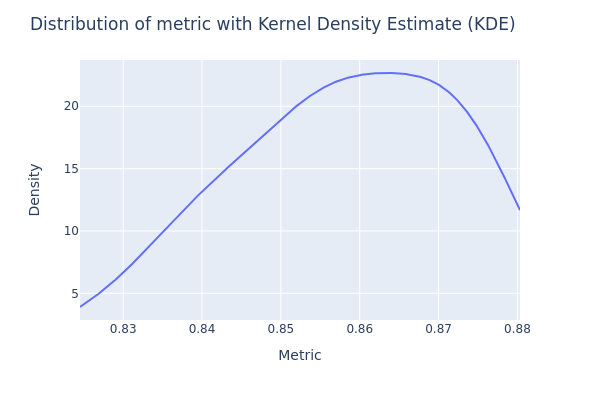

In [10]:
tracker.plot.kde(fig_type="png")

### Reference Plot

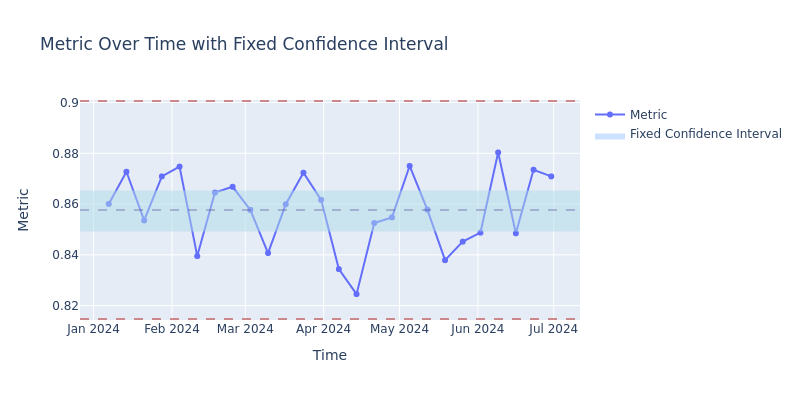

In [11]:
tracker.plot.performance_by_time(tracker.reference_distribution, fig_type="png")

### Analysis Plot

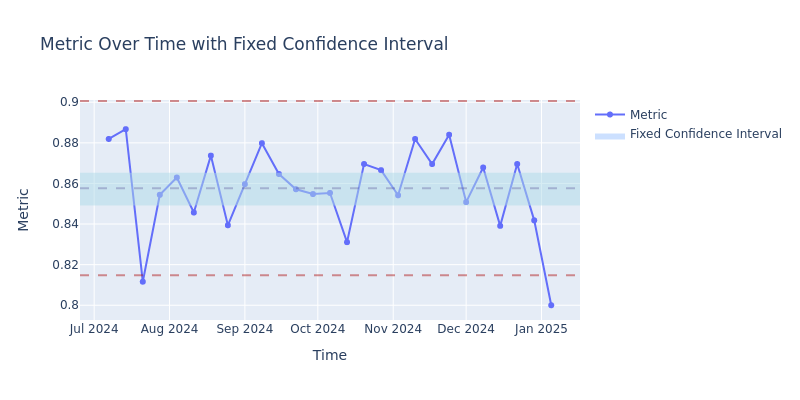

In [12]:
analysis_score = tracker.score(df_test, 'target', 'prediction', 'datetime')
tracker.plot.performance_by_time(analysis_score, fig_type="png")

# Discrete Data Drift

### Median Absolute Deviation (MAD)

In [13]:
# Exemplo de uso:
detector = CategoricalDriftDetector(df_reference, 'discrete_1', "datetime", "W", drift_limit='mad')

#### Reference Plot

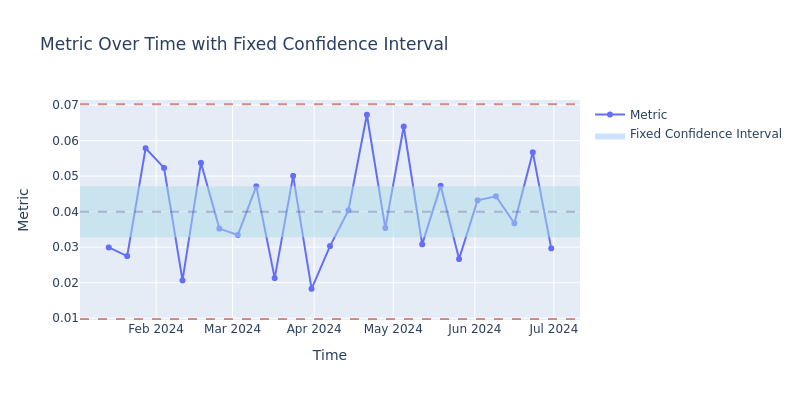

In [14]:
detector.plot.performance_by_time(detector.reference_distribution, fig_type="png")

#### Reference Analysis

In [15]:
analysis_score = detector.score(df_test, "discrete_1", "datetime")

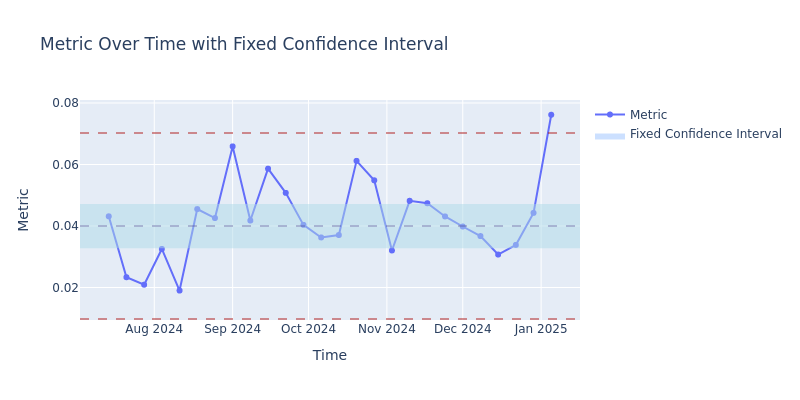

In [16]:
detector.plot.performance_by_time(analysis_score, fig_type="png")

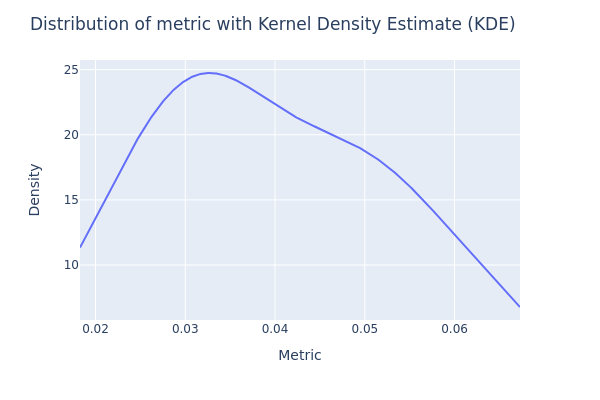

In [17]:
detector.plot.kde(fig_type="png")

### Interquartile Range (iqr)

In [18]:
# Exemplo de uso:
detector = CategoricalDriftDetector(df_reference, 'discrete_0', "datetime", "W", drift_limit="iqr")

#### Reference Plot

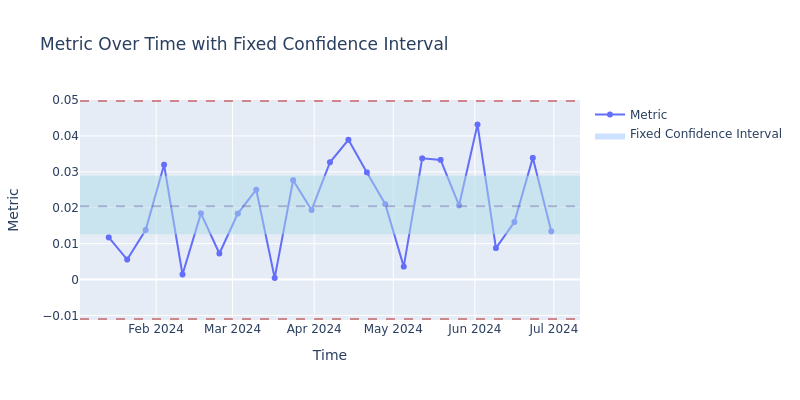

In [19]:
detector.plot.performance_by_time(detector.reference_distribution, fig_type="png")

#### Reference Analysis

In [20]:
analysis_score = detector.score(df_test, "discrete_0", "datetime")

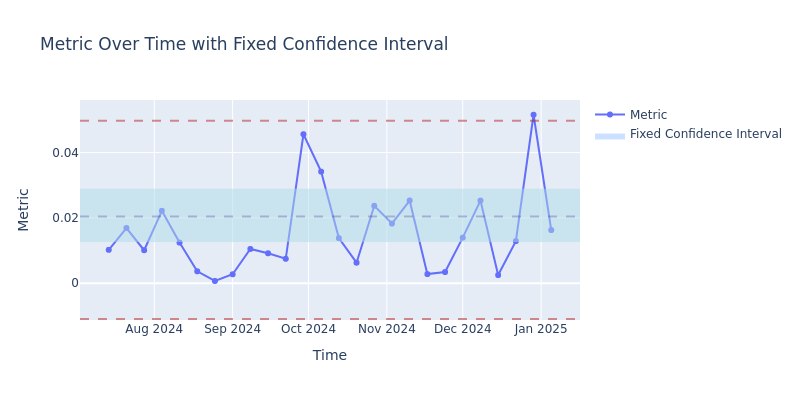

In [21]:
detector.plot.performance_by_time(analysis_score, fig_type="png")

# Continuous Data Drift

In [22]:
ks = ContinuousDriftDetector(df_reference, "feature_0", "datetime", "W", drift_limit=(0.05, None))

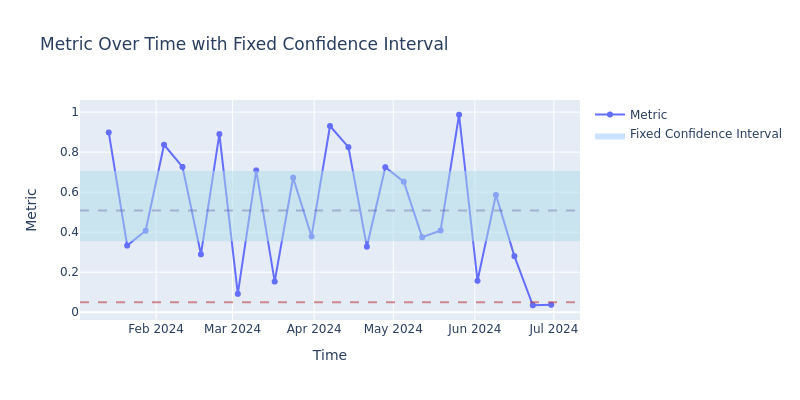

In [23]:
ks.plot.performance_by_time(ks.reference_ks, fig_type="png")

In [24]:
test_ks = ks.score(df_test, "feature_0", "datetime")

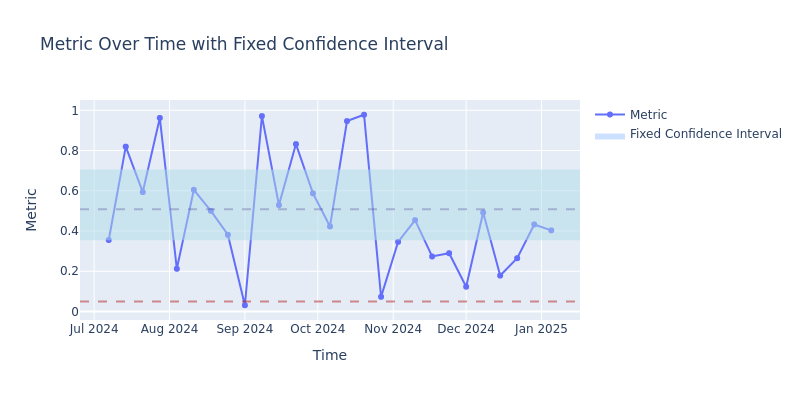

In [25]:
ks.plot.performance_by_time(test_ks, fig_type="png")

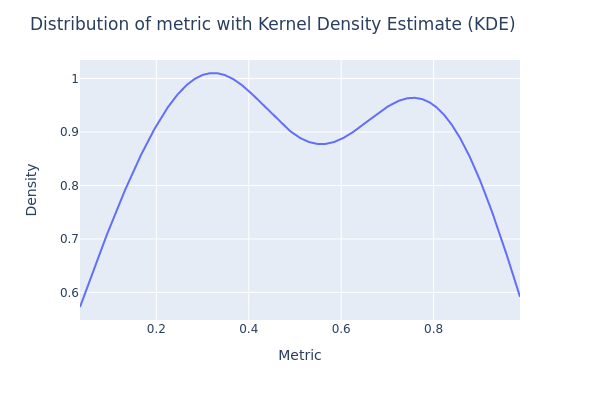

In [26]:
ks.plot.kde(fig_type="png")